In [29]:
import pandas as pd

In [30]:
df_bandarban = pd.read_csv('../1980-2024-dataset/Bandarban_historical_weather_1980_2024.csv')

In [31]:
desired_colmn = ['day', 'month', 'year', 'temperature(degree C)', 'humidity']

df_bandarban = df_bandarban[desired_colmn]
df_bandarban.describe()

,day,month,year,temperature(degree C),humidity
count,16437.000000,16437.000000,16437.000000,14764.000000,14764.000000
mean,15.730243,6.522723,2002.000000,26.154403,77.653698
std,8.800616,3.448865,12.988187,3.447506,9.532762
min,1.000000,1.000000,1980.000000,6.100000,8.200000
25%,8.000000,4.000000,1991.000000,23.900000,72.700000
50%,16.000000,7.000000,2002.000000,27.200000,78.900000
75%,23.000000,10.000000,2013.000000,28.700000,83.800000
max,31.000000,12.000000,2024.000000,34.200000,100.000000


In [32]:
with_no_null = df_bandarban.dropna()
print(f"After removing missing values from bandarban, dataset contains {with_no_null.shape[0]} rows and {with_no_null.shape[1]} columns out of {df_bandarban.shape[0]} rows.")
with_no_null.head()

After removing missing values from bandarban, dataset contains 14764 rows and 5 columns out of 16437 rows.


,day,month,year,temperature(degree C),humidity
6,7,1,1980,6.1,41.9
386,21,1,1981,17.6,80.0
731,1,1,1982,17.1,82.5
732,2,1,1982,6.6,70.3
733,3,1,1982,24.1,8.2


In [33]:

# count zeros per column and show as a table
zeros_per_col = (with_no_null == 0).sum()
zeros_df = zeros_per_col.to_frame(name='zero_count')
zeros_df['zero_percentage'] = (zeros_df['zero_count'] / len(with_no_null) * 100).round(2)
zeros_df = zeros_df[zeros_df['zero_count'] > 0].sort_values('zero_count', ascending=False)

print("Number of zeros per column (only columns with > 0 zeros shown):")
display(zeros_df)

# drop rows that contain any 0 or 0.0 and update with_no_null_HI
rows_before = with_no_null.shape[0]
with_no_null_HI = with_no_null[(with_no_null != 0).all(axis=1)]
rows_after = with_no_null_HI.shape[0]
print(f"Dropped {rows_before - rows_after} rows containing zero values. New shape: {with_no_null_HI.shape}")

Number of zeros per column (only columns with > 0 zeros shown):


,zero_count,zero_percentage


Dropped 0 rows containing zero values. New shape: (14764, 5)


# converting to time series

C:\Users\Khalid\AppData\Local\Temp\ipykernel_10036\1645595947.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  with_no_null['date'] = pd.to_datetime(with_no_null[['year', 'month', 'day']])


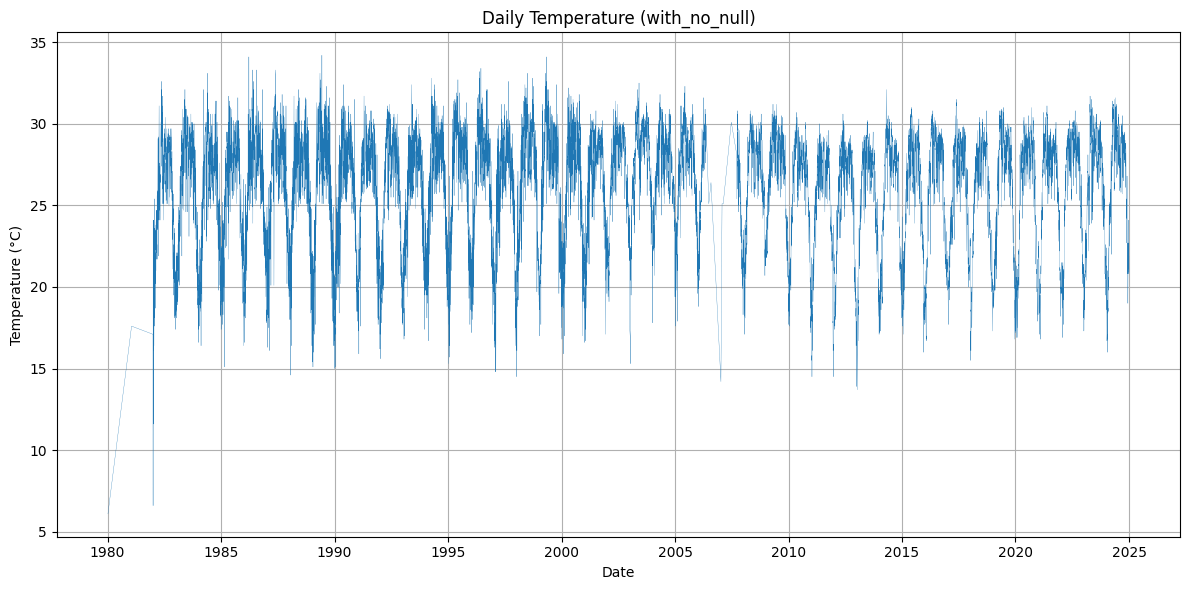

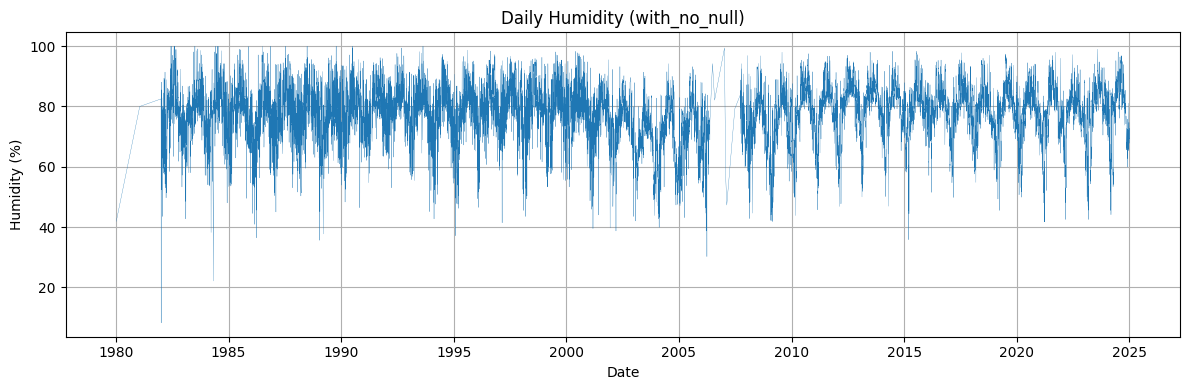

In [34]:
import matplotlib.pyplot as plt

if 'date' not in with_no_null.columns:
    with_no_null['date'] = pd.to_datetime(with_no_null[['year', 'month', 'day']])

min_date = with_no_null['date'].min()
max_date = with_no_null['date'].max()

plt.figure(figsize=(12, 6))
plt.plot(with_no_null['date'], with_no_null['temperature(degree C)'], linewidth=0.2)
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.title('Daily Temperature (with_no_null)')
plt.grid(True)
plt.tight_layout()
plt.show()

# plot daily humidity time series
plt.figure(figsize=(12, 4))
plt.plot(with_no_null['date'], with_no_null['humidity'], linewidth=0.2)
plt.xlabel('Date')
plt.ylabel('Humidity (%)')
plt.title('Daily Humidity (with_no_null)')
plt.grid(True)
plt.tight_layout()
plt.show()


In [35]:
with_no_null.head()

,day,month,year,temperature(degree C),humidity,date
6,7,1,1980,6.1,41.9,1980-01-07
386,21,1,1981,17.6,80.0,1981-01-21
731,1,1,1982,17.1,82.5,1982-01-01
732,2,1,1982,6.6,70.3,1982-01-02
733,3,1,1982,24.1,8.2,1982-01-03


# Random Forest

In [43]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
from sklearn.model_selection import KFold

df = with_no_null.copy()
if 'date' not in df.columns:
    df['date'] = pd.to_datetime(df[['year', 'month', 'day']])


temp_col = 'temperature(degree C)'
hum_col = 'humidity'

desired_col = ['day', 'month', 'year', temp_col, hum_col]

df = df[desired_col].copy()

df['date'] = pd.to_datetime(df[['year', 'month', 'day']])
df = df.sort_values('date').reset_index(drop=True)

df['day_of_year'] = df['date'].dt.dayofyear

def add_fourier_features(df,col,period,n_terms=3):
    for n in range(1, n_terms + 1):
        df[f'{col}_sin_{n}'] = np.sin(2 * np.pi * n * df.index / period)
        df[f'{col}_cos_{n}'] = np.cos(2 * np.pi * n * df.index / period)
    return df

df = add_fourier_features(df, 'day_of_year', period=365, n_terms=3)
fourier_cols = [c for c in df.columns if c.startswith('day_of_year_sin') or c.startswith('day_of_year_cos')]

FEATURES = ['day', 'month', 'year' ] + fourier_cols

X = df[FEATURES]
y = pd.DataFrame({
    'temperature': with_no_null[temp_col],
    'humidity': with_no_null[hum_col]
}).astype(float)    

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

targets = y.columns
rf_model = {}
y_preds = {}
rmses = {}
r2s = {}

for target in targets:
    rf_model = RandomForestRegressor(
        n_estimators= 800 ,
        random_state=42,
        max_depth=100,
        min_samples_split=2,
        min_samples_leaf=1,
        n_jobs=-1,
        max_features='sqrt'
    )
    rf_model.fit(X_train, y_train[target])

    y_pred = rf_model.predict(X_test)


    # model evaluation
    mse_xgb = mean_squared_error(y_test[target], y_pred)
    rmse_xgb = np.sqrt(mse_xgb)
    r2_xgb = r2_score(y_test[target], y_pred)

    print(f"\nRandom Forest Results for {target}:")
    print(f'MSE: {mse_xgb:.4f}')
    print(f'RMSE: {rmse_xgb:.4f}')
    print(f'R² Score: {r2_xgb:.4f}')

    # k fold cross-validation
    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    rmse_list_rf = []
    for train_index, test_index in kf.split(X):
        X_train_kf, X_test_kf = X.iloc[train_index], X.iloc[test_index]
        y_train_kf = y.iloc[train_index][target]
        y_test_kf = y.iloc[test_index][target]
        
        rf_model_kf = RandomForestRegressor(
            n_estimators= 800 ,
            random_state=42,
            max_depth=100,
            min_samples_split=2,
            min_samples_leaf=1,
            n_jobs=-1,
            max_features='sqrt'
        )

        rf_model_kf.fit(X_train_kf, y_train_kf)
        y_pred_kf_rf = rf_model_kf.predict(X_test_kf)

        mse_kf_rf = mean_squared_error(y_test_kf, y_pred_kf_rf)
        rmse_kf_rf = np.sqrt(mse_kf_rf)
        rmse_list_rf.append(rmse_kf_rf)
        average_rmse_rf = np.mean(rmse_list_rf)
        r2_kf_rf = r2_score(y_test_kf, y_pred_kf_rf)

    print(f"Average RMSE from K-Fold CV (Random Forest): {average_rmse_rf:.4f}")
    print(f"RMSEs from each fold (Random Forest): {rmse_list_rf}")
    print(f"K fold R²   : {r2_kf_rf:.4f}")
    print(f"K fold MSE  : {mse_kf_rf:.4f}")
    
# Feature importance for Random Forest
    importance = rf_model.feature_importances_
    feature_names = X.columns
    feature_importance_df_rf = pd.DataFrame({'Feature': feature_names, 'Importance': importance})
    feature_importance_df_rf = feature_importance_df_rf.sort_values(by='Importance', ascending=False)
    print("\nRandom Forest Feature Importances:")
    print(feature_importance_df_rf)


# when n = 3 
# temperature: RMSE=1.3715, R²=0.8349, MSE=1.8810
# temperature: CV RMSE=1.4089 ± 0.0241
# temperature: CV R²=0.8401, CV MSE=2.0237
# humidity: RMSE=6.5602, R²=0.5356, MSE=43.0362
# humidity: CV RMSE=6.6293 ± 0.1343
# humidity: CV R²=0.4863, CV MSE=46.6283


Random Forest Results for temperature:
MSE: 1.8798
RMSE: 1.3710
R² Score: 0.8350
Average RMSE from K-Fold CV (Random Forest): 1.4083
RMSEs from each fold (Random Forest): [np.float64(1.372445826616573), np.float64(1.4444721583092304), np.float64(1.402531022096787), np.float64(1.4003768137743484), np.float64(1.4218666234356692)]
K fold R²   : 0.8403
K fold MSE  : 2.0217

Random Forest Feature Importances:
             Feature  Importance
1              month    0.509323
2               year    0.166623
4  day_of_year_cos_1    0.110438
0                day    0.053115
3  day_of_year_sin_1    0.046799
5  day_of_year_sin_2    0.034316
7  day_of_year_sin_3    0.027443
6  day_of_year_cos_2    0.026437
8  day_of_year_cos_3    0.025507

Random Forest Results for humidity:
MSE: 43.0155
RMSE: 6.5586
R² Score: 0.5358
Average RMSE from K-Fold CV (Random Forest): 6.6268
RMSEs from each fold (Random Forest): [np.float64(6.558742704107125), np.float64(6.73993288171489), np.float64(6.534537626776145)

In [37]:
#  calculating feature importance
importances = {}
for target in targets:
    rf = rf_model[target]
    importances[target] = rf.feature_importances_
importances_df = pd.DataFrame(importances, index=FEATURES)
importances_df = importances_df.sort_values(by=targets[0], ascending=False)
print(importances_df)

                   temperature  humidity
month                 0.503931  0.263493
year                  0.169436  0.247082
day_of_year_cos_1     0.110282  0.092092
day                   0.054863  0.113135
day_of_year_sin_1     0.047077  0.067083
day_of_year_sin_2     0.035342  0.061248
day_of_year_cos_2     0.027219  0.050300
day_of_year_cos_3     0.026325  0.050501
day_of_year_sin_3     0.025525  0.055065


In [44]:
# probabilistic random forest using quantile regression forest
from sklearn.ensemble import RandomForestQuantileRegressor
rf_quantile_model = {}
quantiles = [0.05, 0.5, 0.95]
for target in targets:
    rf_quantile = RandomForestQuantileRegressor(
        n_estimators=800,
        random_state=42,
        max_depth=100,
        min_samples_split=2,
        min_samples_leaf=1,
        n_jobs=-1,
        max_features='sqrt'
    )
    rf_quantile.fit(X_train, y_train[target])
    rf_quantile_model[target] = rf_quantile
    for q in quantiles:
        y_pred_quantile = rf_quantile.predict(X_test, quantile=q)
        print(f"\nQuantile {q} predictions for {target}:")
        print(y_pred_quantile)
    # Evaluate median predictions
    y_pred_median = rf_quantile.predict(X_test, quantile=0.5)
    mse_quantile = mean_squared_error(y_test[target], y_pred_median)
    rmse_quantile = np.sqrt(mse_quantile)
    r2_quantile = r2_score(y_test[target], y_pred_median)
    print(f"\nQuantile Random Forest Results for {target} (Median Predictions):")
    print(f'MSE: {mse_quantile:.4f}')
    print(f'RMSE: {rmse_quantile:.4f}')
    print(f'R² Score: {r2_quantile:.4f}')

    

ImportError: cannot import name 'RandomForestQuantileRegressor' from 'sklearn.ensemble' (c:\Python313\Lib\site-packages\sklearn\ensemble\__init__.py)

# XGBoost 

In [38]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.multioutput import MultiOutputRegressor

def within_tolerance_acc(y_true, y_hat, tol):
    # returns fraction (0..1) of predictions within tol across all targets
        return ((np.abs(y_true - y_hat) <= tol).mean())

for target in targets:
    xgb_model = xgb.XGBRegressor(
        objective='reg:squarederror',
        n_estimators=800,
        learning_rate=0.1,
        max_depth=5,
        random_state=42
    )
    xgb_model.fit(X_train, y_train[target])

    y_pred = xgb_model.predict(X_test)

    mse_xgb = mean_squared_error(y_tests, y_pred)
    rmse_xgb = np.sqrt(mse_xgb)
    r2_xgb = r2_score(y_tests, y_pred)

    xgboost_acc_05 = within_tolerance_acc(y_test[targets].values, y_pred, 0.5)
    xgboost_acc_10 = within_tolerance_acc(y_test[targets].values, y_pred, 1.0)
    xgboost_acc_20 = within_tolerance_acc(y_test[targets].values, y_pred, 2.0)
    xgboost_acc_30 = within_tolerance_acc(y_test[targets].values, y_pred, 3.0)

    print(f"\nXGBoost Results for {target}:")
    print(f'Mean Squared Error: {mse_xgb:.4f}')
    print(f'RMSE: {rmse_xgb:.4f}')
    print(f'R² Score: {r2_xgb:.4f}')
    # K-Fold cross-validation for XGBoost
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    rmse_list_xgb = []
    for train_index, test_index in kf.split(X):
        X_train_kf, X_test_kf = X.iloc[train_index], X.iloc[test_index]
        y_train_kf = y.iloc[train_index][target]
        y_test_kf = y.iloc[test_index][target]

        xgb_model_kf = xgb.XGBRegressor(
            objective='reg:squarederror',
            n_estimators=800,
            learning_rate=0.1,
            max_depth=5,
            random_state=42
        )

        xgb_model_kf.fit(X_train_kf, y_train_kf)
        y_pred_kf_xgb = xgb_model_kf.predict(X_test_kf)


        mse_kf_xgb = mean_squared_error(y_test_kf, y_pred_kf_xgb)
        rmse_kf_xgb = np.sqrt(mse_kf_xgb)
        rmse_list_xgb.append(rmse_kf_xgb)
        average_rmse_xgb = np.mean(rmse_list_xgb)
        r2_kf_xgb = r2_score(y_test_kf, y_pred_kf_xgb)

    print(f"Average MSE from K-Fold CV (XGBoost): {average_rmse_xgb:.4f}")
    print(f"MSEs from each fold (XGBoost): {rmse_list_xgb}")
    print(f"K fold R²   : {r2_kf_xgb:.4f}")
    print(f"K fold MSE  : {mse_kf_xgb:.4f}")
    
# Feature importance for XGBoost
    importance = xgb_model.feature_importances_
    feature_names = X.columns
    feature_importance_df_xgb = pd.DataFrame({'Feature': feature_names, 'Importance': importance})
    feature_importance_df_xgb = feature_importance_df_xgb.sort_values(by='Importance', ascending=False)
    print("\nXGBoost Feature Importances:")
    print(feature_importance_df_xgb)



ValueError: operands could not be broadcast together with shapes (2953,2) (2953,) 

# Light GBM

In [ ]:
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.multioutput import MultiOutputRegressor

for target in targets:
    base_lgb = lgb.LGBMRegressor(
        n_estimators=500,
        learning_rate=0.05,
        max_depth=-1,
        subsample=0.9,
        colsample_bytree=0.9,
        random_state=42
    )

    lgb_model = MultiOutputRegressor(base_lgb)
    lgb_model.fit(X_train, y_train)

    y_pred = lgb_model.predict(X_test)

    lgb_r2_f  = r2_score(y_test, y_pred)
    lgb_mse_f = mean_squared_error(y_test, y_pred)
    lgb_rmse_f = np.sqrt(lgb_mse_f)

    def within_tolerance_acc(y_true, y_hat, tol):
        return ((np.abs(y_true - y_hat) <= tol).mean())

    lgb_acc_05 = within_tolerance_acc(y_test.values, y_pred, 0.5)
    lgb_acc_10 = within_tolerance_acc(y_test.values, y_pred, 1.0)
    lgb_acc_20 = within_tolerance_acc(y_test.values, y_pred, 2.0)
    lgb_acc_30 = within_tolerance_acc(y_test.values, y_pred, 3.0)

    print("==== LightGBM Regression Metrics (Test) ====")
    print(f"LGB_R^2  : {lgb_r2_f:.4f}")
    print(f"LGB_MSE  : {lgb_mse_f:.4f}")
    print(f"LGB_RMSE : {lgb_rmse_f:.4f}")
    print("Accuracy (|error| ≤ tolerance):")
    print(f"  ±0.5°C : {lgb_acc_05*100:.2f}%")
    print(f"  ±1.0°C : {lgb_acc_10*100:.2f}%")
    print(f"  ±2.0°C : {lgb_acc_20*100:.2f}%")
    print(f"  ±3.0°C : {lgb_acc_30*100:.2f}%")

    # --- 6) 5-fold CV R^2 ---
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    cv_r2 = cross_val_score(lgb_model, X, y, cv=cv, scoring="r2", n_jobs=-1)

    print("\n==== 5-Fold CV R^2 ====")
    print(f"Mean LGB_R^2 : {cv_r2.mean():.4f}  |  Std : {cv_r2.std():.4f}")

    # --- 7) Feature importances (average across outputs) ---
    importances = np.array([est.feature_importances_ for est in lgb_model.estimators_])
    mean_importance = importances.mean(axis=0)
    fi = pd.DataFrame({"feature": FEATURES, "importance": mean_importance}).sort_values("importance", ascending=False)

    print("\n==== Top Feature Importances ====")
    print(fi.to_string(index=False))

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000102 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1615
[LightGBM] [Info] Number of data points in the train set: 11811, number of used features: 9
[LightGBM] [Info] Start training from score 26.148861
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000271 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1615
[LightGBM] [Info] Number of data points in the train set: 11811, number of used features: 9
[LightGBM] [Info] Start training from score 77.671781
==== LightGBM Regression Metrics (Test) ====
LGB_R^2  : 0.6849
LGB_MSE  : 22.8130
LGB_RMSE : 4.7763
Accuracy (|error| ≤ tolerance):
  ±0.5°C : 19.07%
  ±1.0°C : 35.95%
  ±2.0°C : 58.21%
  ±3.0°C : 68.54%

==== 5-Fold CV R^2 ====
Mean LGB_R^2 : 0.6763  